### Importing the dependencies

In [29]:
# For data visualization and manipulation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import re

# For data processing
from sklearn.impute import KNNImputer
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OrdinalEncoder,PowerTransformer,MinMaxScaler)
from sklearn.model_selection import train_test_split

print("Everything imported successfully😊")

Everything imported successfully😊


### Dataset desciption
- VoLTE stands for Voice over LTE. It is a technology that allows you to make and receive calls over the LTE network. This means that you can enjoy better call quality and voice clarity, even when you are in a poor cellular reception area.- 
Wi-Fi is a wireless networking technology that allows you to connect to the internet without using a cellular network. This is a great way to save on your data plan, especially if you are using a lot of data for streaming videos or music
  .- 
IR Blaster is a small infrared transmitter that is built into some smartphones. It allows you to use your phone as a remote control for other devices, such as your TV, air conditioner, or stere
- NFC stands for Near Field Communication. It is a short-range wireless technology that allows two devices to communicate with each other when they are brought within close proximity. The maximum distance for NFC communication is about 4 inches.o.

In [2]:
# Loading the data from csv file to dataframe
df = pd.read_csv('Data.csv')

### Exploratory data analysis

In [3]:
# Checking shape of the dataframe
print("Shape of the dataframe : ",df.shape)

Shape of the dataframe :  (1020, 11)


In [4]:
# Checking any 3 random rows of the dataframe
df.sample(3)

,model,price,rating,sim,processor,ram,battery,display,camera,card,os
890,OnePlus Ace 5G,"₹28,990",84.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Dimensity 8100 Max, Octa Core, 2.85 GHz Processor","8 GB RAM, 128 GB inbuilt",4500 mAh Battery with 150W Fast Charging,"6.7 inches, 1080 x 2412 px, 120 Hz Display wit...",50 MP + 8 MP + 2 MP Triple Rear & 16 MP Front ...,Android v12,No FM Radio
354,Xiaomi Redmi K60 Pro,"₹38,999",85.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC, IR Bl...","Snapdragon 8 Gen2, Octa Core, 3.2 GHz Processor","8 GB RAM, 128 GB inbuilt",5000 mAh Battery with 120W Fast Charging,"6.67 inches, 1440 x 3200 px, 120 Hz Display wi...",54 MP + 8 MP + 2 MP Triple Rear & 16 MP Front ...,Android v13,No FM Radio
487,Sony Xperia 5 II,"₹69,990",86.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Snapdragon 865 , Octa Core, 2.84 GHz Processor","8 GB RAM, 128 GB inbuilt",4000 mAh Battery with 21W Fast Charging,"6.1 inches, 1080 x 2520 px, 120 Hz Display",12 MP + 12 MP + 12 MP Triple Rear & 8 MP Front...,Memory Card (Hybrid),Android v10


In [5]:
# Let's take a look at the informatoin related to columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   model      1020 non-null   object 
 1   price      1020 non-null   object 
 2   rating     879 non-null    float64
 3   sim        1020 non-null   object 
 4   processor  1020 non-null   object 
 5   ram        1020 non-null   object 
 6   battery    1020 non-null   object 
 7   display    1020 non-null   object 
 8   camera     1019 non-null   object 
 9   card       1013 non-null   object 
 10  os         1003 non-null   object 
dtypes: float64(1), object(10)
memory usage: 87.8+ KB


model         0.000000
price         0.000000
rating       13.823529
sim           0.000000
processor     0.000000
ram           0.000000
battery       0.000000
display       0.000000
camera        0.098039
card          0.686275
os            1.666667
dtype: float64


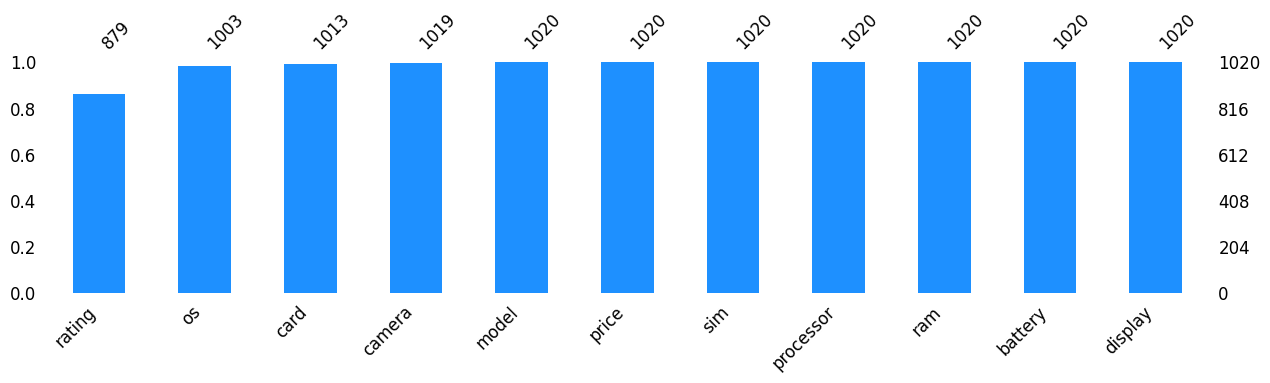

In [6]:
# Checking any missing values
print(df.isnull().mean()*100)

# Visualize missing values using a bar chart
msno.bar(df, figsize=(15, 3), color="dodgerblue", sort="ascending", fontsize=12)
plt.show()

In [7]:
# Let's check if there are any duplicate valeus
print("Duplicate values :",df.duplicated().sum())

Duplicate values : 0


### Feature engineering

- `price`: Remove rupee and , character
- `sim`: Extracting a binary feature (called sim type 0 : Single sim and 1 : Dual sim)
- `sim`: Extracting a binary feature called (Has_5g)

In [8]:
# Dropping the os
df.drop(['os'],axis=1,inplace=True)

In [9]:
# Removing rupee and , character from the 'price' feature and converting to int
for index in range(len(df)):
    item = df.loc[index, 'price']
    item = item.replace("₹", "").replace(",", "")
    item = re.sub(r'[^\d]', '', item)  # Remove any non-digit characters
    df.loc[index, 'price'] = item

df['price'] = df['price'].astype(np.int64)

- Since NFC and IR blaster are some additional features in smartphones so let's create a binary feature where 1 will represent that this phone as one of additional feature and 0 if the smartphone doesn't have any.
- In our dataset there are few smartphones which don't even have Wifi and VoLTE so we also need to keep these phones into consideration so let's create a binary features for this. 1 : Has_Wifi_Volte and and 0 if not.
  


- 
The "G" in 3G, 4G, and 5G stands for "generation". These terms refer to the different generations of cellular network technolog.It is not necessary for a smartphone to have a "G" in order to be functional.y

In [10]:
str = 'Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC, IR Blaster'
print(str.split(','))

['Dual Sim', ' 3G', ' 4G', ' 5G', ' VoLTE', ' Wi-Fi', ' NFC', ' IR Blaster']


In [11]:
# Empty lists to store data
Sim_type = []
Has_5g = []
Add_Features = []
Volte_Wifi = []

for item in df['sim']:
    Sim_type.append(1 if 'Dual Sim' in item.split(',') else 0)
    Has_5g.append(2 if ' 5G' in item.split(',') else (1 if ' 4G' in item.split(',') or ' 3G' in item.split(',') else 0))
    Add_Features.append(1 if ' NFC' in item.split(',') or ' IR Blaster' in item.split(',') else 0)
    Volte_Wifi.append(1 if ' VoLTE' in item.split(',') and ' Wi-Fi' in item.split(',') else 0)


# Convert lists to pandas Series
df['Sim_type'] = pd.Series(Sim_type)
df['Has_5g'] = pd.Series(Has_5g)
df['Add_Features'] = pd.Series(Add_Features)
df['Volte_Wifi'] = pd.Series(Volte_Wifi)
df.drop(['sim'],axis =1,inplace=True)

Just like we extracted some useful features from the sim feature we will now again extract some useful information from the ram feature.Non-breaking spaces are invisible characters that are used to prevent words from breaking at the end of a line. They are represented by the Unicode character \u2009.

In [12]:
str = '6 GB RAM, 128 GB inbuilt'
str.split()

['6', 'GB', 'RAM,', '128', 'GB', 'inbuilt']

In [13]:
RAM = []
Storage = []

for item in df['ram']:
    contents = item.split()
    if ('RAM,' in contents) or ('inbuilt' in contents):  # Filtered out any wrong info

        # Now we just need to figure out if both are present or only one is present
        if ('RAM,' in contents) and ('inbuilt' in contents):
            RAM.append(int(contents[0]))
            Storage.append(int(contents[3]))
        elif 'RAM,' in contents:
            RAM.append(int(contents[0]))
            Storage.append(np.nan)
        elif 'inbuilt' in contents:
            RAM.append(np.nan)
            Storage.append(int(contents[0]))
            
    else:
        RAM.append(np.nan)
        Storage.append(np.nan)

df['RAM'] = pd.Series(RAM)
df['Storage'] = pd.Series(Storage)
df.drop(['ram'], axis=1, inplace=True)

Just like the RAM and storage let's now extract the battery and charging W from the battery feature

In [14]:
str1 = '5000 mAh Battery with 455W Fast Charging'
# int(str1.split()[4][:-1])

str2 = '3095 mAh Battery with Fast Charging'
print(str1.split())
print(str2.split())

['5000', 'mAh', 'Battery', 'with', '455W', 'Fast', 'Charging']
['3095', 'mAh', 'Battery', 'with', 'Fast', 'Charging']


In [15]:
Battery = []
Charging = []

for item in df['battery']:
    contents = item.split()
    if ('Battery' in contents) or ('Charging' in contents):  # Filtered out any wrong info

        if ('Battery' in contents) and ('Charging' in contents) and len(contents) == 7:
            Battery.append(int(contents[0]))
            Charging.append(float(contents[4][:-1]))

        # Means keywords are present but value of fast charging is not mentioned
        elif ('Battery' in contents) and ('Charging' in contents) and len(contents) == 6:
            Battery.append(int(contents[0]))
            Charging.append(np.nan)

        elif 'Battery' in contents:
            Battery.append(int(contents[0]))
            Charging.append(np.nan)
                 
    else:
        Battery.append(np.nan)
        Charging.append(np.nan)

df['Battery'] = pd.Series(Battery)
df['Charging'] = pd.Series(Charging)
df.drop(['battery'], axis=1, inplace=True)

Now first we will extract the pixels and screen size of each of the smartphone and we will calculate its PPI.The PPI of a display is calculated by dividing the total number of pixels in the display by the diagonal length of the display in inches. In your case, the display has a resolution of 1440 x 3216 pixels and a diagonal length of 6.7 inches. So, the PPI of the display would be:

PPI = pixels / diagonal_inches
= 1440 * 3216 / 6.7
= 69,1200

In [16]:
str1 = '6.7 inches, 1440 x 3216 px, 120 Hz Display with Punch Hole'
str2 = '2.4 inches, 320 x 240 px Display'
print(str1.split())
print(str2.split())

['6.7', 'inches,', '1440', 'x', '3216', 'px,', '120', 'Hz', 'Display', 'with', 'Punch', 'Hole']
['2.4', 'inches,', '320', 'x', '240', 'px', 'Display']


In [17]:
diagonal_len = []
Total_px = []

for item in df['display']:
    contents = item.split()
    if ('inches,' in contents) and ('Display'):  # Filtered out any wrong info

        diagonal_len.append(float(contents[0]))
        px1_val = contents[2]
        px2_val = contents[4]
        total_px_value = int(px1_val) * int(px2_val)
        Total_px.append(total_px_value)
            
    else:
        diagonal_len.append(np.nan)
        Total_px.append(np.nan)

df['diagonal_len'] = pd.Series(diagonal_len)
df['Total_px'] = pd.Series(Total_px)
df.drop(['display'], axis=1, inplace=True)

- Total rear cameras
- Front camera MP

In [18]:
str = '50 MP + 48 MP + 32 MP Triple Rear & 16 MP Front Camera'
print(str.split())
print(str.split('&')[-1].split()[0])

['50', 'MP', '+', '48', 'MP', '+', '32', 'MP', 'Triple', 'Rear', '&', '16', 'MP', 'Front', 'Camera']
16


In [19]:
rear_cams = []
Total_fmp = []

df['camera'].fillna(df['camera'].mode()[0],inplace=True)

for item in df['camera']:
    contents = item.split()
    if ('Rear' in contents) and ('Front' in contents) and ('&' in contents):  # Filtered out any wrong info

        if 'Quad' in contents:
            rear_cams.append(4)
        elif 'Triple' in contents:
            rear_cams.append(3)
        elif 'Dual' in contents:
            rear_cams.append(2)
        else:
            rear_cams.append(1)
            
        Total_fmp.append(float(item.split('&')[-1].split()[0]))
            
    else:
        rear_cams.append(np.nan)
        Total_fmp.append(np.nan)

df['rear_cams'] = pd.Series(rear_cams)
df['Total_fmp'] = pd.Series(Total_fmp)
df.drop(['camera'], axis=1, inplace=True)

Since there is some wrong infromation stored in the card attribute so we will replace all the wrong information with null values.

In [20]:
# Remvoing any unrelated information
for i in range(len(df)):
    item = df.loc[i, 'card']
    if pd.isna(item) == False and 'Memory' not in item.split():
        df.loc[i,'card'] = np.nan

df.loc[df["card"] == "Memory Card Supported, upto 1000 GB","card"] = "Memory Card Supported, upto 1 TB"

# Considering only the name of the processor and brand
for i in range(len(df)):
    item1 = df.loc[i,'processor']
    item2 = df.loc[i,'model']
    df.loc[i,'processor'] = item1.split()[0]
    df.loc[i,'model'] = item2.split()[0]

In [21]:
# Let's fix some errors
df.loc[(df["processor"] == "A13") | (df["processor"] == "Apple"), "processor"] = "Bionic"
df.loc[df["processor"] == "Helio,","processor"] = "Helio"
df.loc[df["processor"] == "Unisoc,","processor"] = "Unisoc"
df.loc[df["processor"] == "Sanpdragon","processor"] = "Snapdragon"

# Sort of doing mode imputation
types = ['1', '4', 'SC9863A,', '32', '1.77', 'SC6531E,', '48','256', 'Single', 'Samsung', '(28', 'Fusion',
 '52', '2000', '800','1450', 'Dual', '8']

for type in types:
    df.loc[df["processor"] == type,"processor"] = "Snapdragon"

### Data processsing

- `Handling missing valeus` : Based on the percentage of missing values in each of the feature we will use the respective technqiue.
- `Handling outliers`
- `Encoding categorical features` : Out of all the features model,processor and card are categorical features and out of these 3 features card is ordinal feature where as model and processor are nominal features.

**Note**: For data processing we will be using pipeline but just for exporatory purpose we will create a copy of the original dataframe and once we will finalize what we need to do we will simply use pipeline on the original dataframe

In [31]:
train_df,test_val_df = train_test_split(df,train_size = 0.8)
test_df,val_df = train_test_split(test_val_df,train_size = 0.5)

# Creating a copy of the training dataframe
temp_df = train_df.copy()

In [35]:
train_df.shape,test_df.shape,val_df.shape

((816, 17), (102, 17), (102, 17))

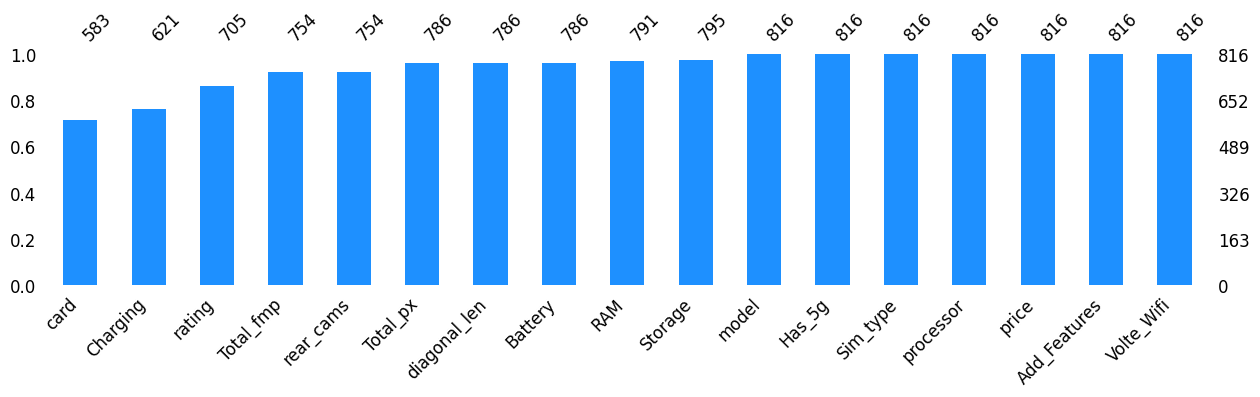

In [36]:
# Visualizing the missing values
msno.bar(temp_df, figsize=(15, 3), color="dodgerblue", sort="ascending", fontsize=12)
plt.show()

From the above matrix it is visible that there are missing values but our selection of technqiue to deal with them will be based on the percentage of missing values.
- For features with less than 10% Missing values we will use simple univariate imputation techniques
- For features with more than 10% Missing values we will use the multi-variate imputation techniques

In [37]:
# let's get pecentage of missing values
print(temp_df.isnull().mean()*100)

model            0.000000
price            0.000000
rating          13.602941
processor        0.000000
card            28.553922
Sim_type         0.000000
Has_5g           0.000000
Add_Features     0.000000
Volte_Wifi       0.000000
RAM              3.063725
Storage          2.573529
Battery          3.676471
Charging        23.897059
diagonal_len     3.676471
Total_px         3.676471
rear_cams        7.598039
Total_fmp        7.598039
dtype: float64


In [38]:
# Let's get all teh features with 0 to 10% missing values
Less_10_Nan = [col for col in temp_df.columns if temp_df[col].isnull().mean()*100 > 0 and temp_df[col].isnull().mean()*100 < 10]
print(Less_10_Nan)

['RAM', 'Storage', 'Battery', 'diagonal_len', 'Total_px', 'rear_cams', 'Total_fmp']


All features having less than 10% Missing values are categorical in nature so we will be using the mode imputation.

In [39]:
# Mode imputation
for cols in Less_10_Nan:
    temp_df[cols].fillna(temp_df[cols].mode()[0],inplace=True)

For features having more than 10% Missing values we will be using the KNN imputer algorithm but before using this algorithm we need to encode the values in the card feature so we will do ordinal encoding of the card feature using the Ordinal encoder class

In [40]:
cols = [
    'Memory Card Not Supported','Memory Card Supported, upto 16 GB','Memory Card Supported, upto 32 GB','Memory Card Supported, upto 48 GB',
    'Memory Card Supported, upto 64 GB','Memory Card Supported, upto 128 GB','Memory Card Supported, upto 256 GB',
    'Memory Card Supported, upto 512 GB','Memory Card Supported, upto 1 TB','Memory Card Supported, upto 2 TB','Memory Card (Hybrid)',
    'Memory Card (Hybrid), upto 64 GB','Memory Card (Hybrid), upto 128 GB','Memory Card (Hybrid), upto 256 GB',
    'Memory Card (Hybrid), upto 512 GB','Memory Card (Hybrid), upto 1 TB','Memory Card (Hybrid), upto 2 TB']

oe_card = OrdinalEncoder(categories=[cols],handle_unknown="use_encoded_value",unknown_value=np.nan)
temp_df['card'] = oe_card.fit_transform(temp_df['card'].values.reshape(-1,1)).reshape(-1)

# Target encoding the model and processor
target_enc = ce.TargetEncoder(smoothing=0.2, handle_missing="return_nan", return_df=False)
for cols in ['model','processor']:
    temp_df[cols] = target_enc.fit_transform(temp_df[cols].values.reshape(-1,1)).reshape(-1)

In [44]:
knn_imputer = KNNImputer(n_neighbors=5, metric="nan_euclidean")

cols = ["rating","Charging","card"]
temp_df[cols] = knn_imputer.fit_transform(temp_df[cols])

In [45]:
temp_df.head(4)

,model,price,rating,processor,card,Sim_type,Has_5g,Add_Features,Volte_Wifi,RAM,Storage,Battery,Charging,diagonal_len,Total_px,rear_cams,Total_fmp
441,Poco,19650,82.0,Snapdragon,10.0,1,1,1,1,6.0,128.0,5160.0,33.0,6.67,2592000.0,4.0,20.0
13,Vivo,16990,80.0,Snapdragon,15.0,1,2,0,1,6.0,128.0,5000.0,18.0,6.58,2600640.0,3.0,16.0
235,Vivo,14499,77.0,Snapdragon,15.0,1,1,0,1,4.0,128.0,5000.0,44.0,6.44,2600640.0,3.0,16.0
239,Vivo,19990,82.0,Helio,15.0,1,1,0,1,8.0,128.0,4050.0,44.0,6.44,2592000.0,3.0,44.0


From my research I came to know that the PPI of a smartphone also contribute in increase in the price of the smartphone. SO let's create a new feature called PPI

In [ ]:
PPI = []
for i in range(len(df))

In [ ]:
def calculate_ppi(total_px,diagonal_len):
    """
    This function will take the total pixels and the diagonal length
    of the smartphone and will return PPI
    """
    

In [24]:
df.head(2)

,model,price,rating,processor,card,Sim_type,Has_5g,Add_Features,Volte_Wifi,RAM,Storage,Battery,Charging,diagonal_len,Total_px,rear_cams,Total_fmp
0,OnePlus,54999,89.0,Snapdragon,Memory Card Not Supported,1,2,1,1,12.0,256.0,5000.0,100.0,6.70,4631040.0,3.0,16.0
1,OnePlus,19989,81.0,Snapdragon,"Memory Card (Hybrid), upto 1 TB",1,2,0,1,6.0,128.0,5000.0,33.0,6.59,2604960.0,3.0,16.0


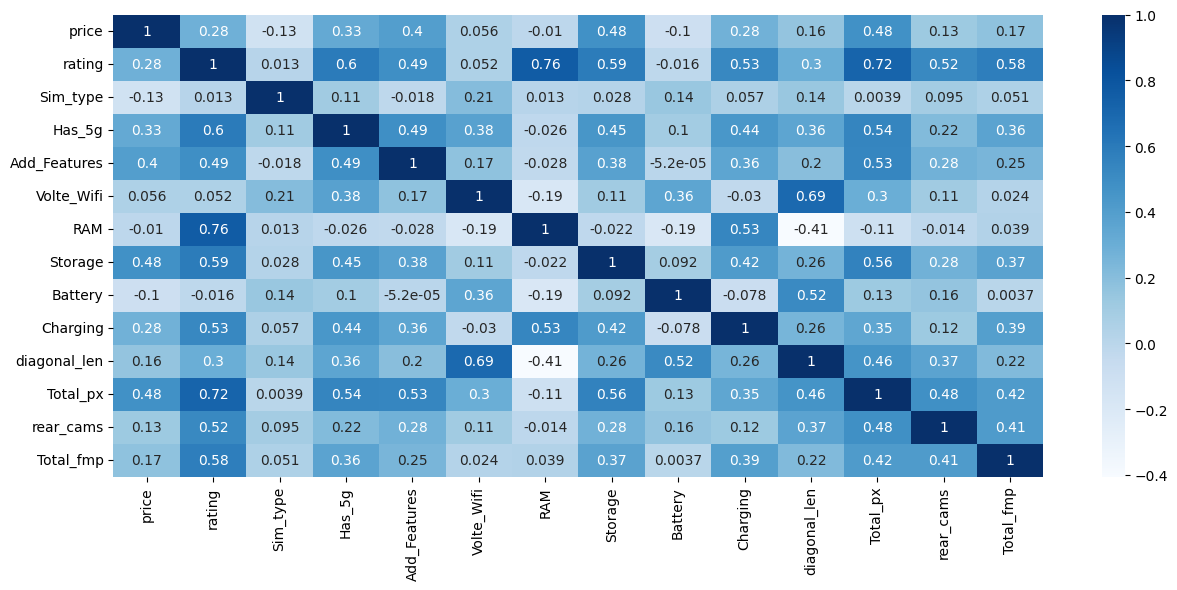

In [33]:
plt.figure(figsize=(15, 6))
sns.heatmap(df[['price', 'rating','Sim_type', 'Has_5g',
       'Add_Features', 'Volte_Wifi', 'RAM', 'Storage', 'Battery', 'Charging',
       'diagonal_len', 'Total_px', 'rear_cams', 'Total_fmp']].corr(), annot=True,cmap="Blues")
plt.show()